# Multiple Layer Perceptron microbiome data classifier

#Aknowledgement
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-2833-2 (https://github.com/ChiehLo/MetaNN).

https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb


In [ ]:
#Import packages

import os, random
from IPython.display import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, ImageFolder
from torchvision.utils import make_grid, save_image

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.metrics import matthews_corrcoef

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
#Load google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Read data file
data_file = F'/content/gdrive/MyDrive/PhD/Coursework/AI in Genomics/Projects/Phyla/phyla_dataset_d3/phyla_dataset_d3.csv'
data_file = F'/content/gdrive/MyDrive/PhD/Coursework/AI in Genomics/Projects/Phyla/phyla_dataset_d3/CLR_normalized_phyla.tsv'

dirc = '/content/gdrive/MyDrive/PhD/Coursework/AI in Genomics/Projects/Phyla/phyla_dataset_d3/MAD/'
file1='phyla_dataset_d3.csv'
file2='CLR_normalized_phyla.tsv'
file3='CLR_normalized_phyla_ALL.tsv'
file4='CLR_normalized_phyla_C5.tsv'
file5='CLR_normalized_phyla_C50.tsv'
file6='CLR_normalized_phyla_C500.tsv'
file7='phyla_all_753x1177_PMI_threshold_0_clr_15p.csv'
file8='phyla_all_4514x1177_PMI_threshold_0_clr_85p.csv'
file9='MAD_85p/phyla_all_4514x1183_MAD_85p.csv'
file10='MAD_85p/phyla_all_noNC_noCS_4050x1183_MAD_85p.csv'
file11='MAD_85p/phyla_biop_1273x1183_MAD_85p.csv'
file12='MAD_85p/phyla_biop_noCS_1252x1183_MAD_85p.csv'
file13='MAD_85p/phyla_stool_3240x1183_MAD_85p.csv'
file14='MAD_85p/phyla_stool_noNC_2798x1183_MAD_85p.csv'

file15='MAD_15p/phyla_all_753x1183_MAD_15p.csv'
file16='MAD_15p/phyla_all_noNC_noCS_676x1183_MAD_15p.csv'
file17='MAD_15p/phyla_biop_213x1183_MAD_15p.csv'
file18='MAD_15p/phyla_biop_noCS_209x1183_MAD_15p.csv'
file19='MAD_15p/phyla_stool_541x1183_MAD_15p.csv'
file20='MAD_15p/phyla_stool_noNC_467x1183_MAD_15p.csv'

dirc = '/content/gdrive/MyDrive/AI in Microbiome/Filtered normalized data/noBE_removal_clr_and_other_normalizations/MAD/'
file1 = 'phyla_all_3949x1177_pmi_0_clr_75p_MAD.csv'
file2 = 'phyla_all_565x1177_pmi_0_clr_10p_MAD.csv'
file3 = 'phyla_all_753x1177_pmi_0_clr_15p_MAD.csv'

#all
file1 = 'phyla_all_3949x1177_pmi_0_clr_75p_MAD.csv' 
file2 = 'phyla_all_565x1177_pmi_0_clr_10p_MAD.csv'
file3 = 'phyla_all_753x1177_pmi_0_clr_15p_MAD.csv'

 #stool
file1 = 'phyla_stool_2840x1177_pmi_0_clr_75p_MAD.csv'
file2 = 'phyla_stool_401x1177_pmi_0_clr_10p_MAD.csv'
file3 = 'phyla_stool_540x1177_pmi_0_clr_15p_MAD.csv'

 #Biopsy
file1 = 'phyla_biopsy_1109x1177_pmi_0_clr_75p_MAD.csv'
file2 = 'phyla_biopsy_164x1177_pmi_0_clr_10p_MAD.csv'
file3 = 'phyla_biopsy_213x1177_pmi_0_clr_15p_MAD.csv'


train_data_file = F'%s' %(dirc + file1.replace('.csv','_edited.csv'))
train_data_file = '/content/gdrive/MyDrive/PhD/Coursework/AI in Genomics/VAE/phyla_dataset_d3_edited_vae.csv'
#test_data_file = F'%s' %(dirc + file20)

train_data_file = dirc + file1
val_data_file = dirc + file2
test_data_file = dirc + file3

In [ ]:
# sets device for model and PyTorch tensors
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set seeds
if True:
    seed = 2021
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device.type=='cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [ ]:
#Pandas data read
if train_data_file.endswith('tsv'):
  microbe_df_train = pd.read_csv(train_data_file, sep='\t')
  microbe_df_val = pd.read_csv(val_data_file, sep='\t')
elif train_data_file.endswith('csv'):
  microbe_df_train = pd.read_csv(train_data_file)
  microbe_df_val = pd.read_csv(val_data_file)
else:
  print('Please make sure file is either tab separated or comma separated')
print(microbe_df_train)

            Unnamed: 0  ...  uc_cd
0       1939.MGH100079  ...     CD
1       1939.MGH100748  ...     CD
2       1939.MGH100826  ...     CD
3     1939.MGH100896.b  ...     CD
4       1939.MGH101003  ...     UC
...                ...  ...    ...
1104        SRR8058649  ...     UC
1105        SRR8058651  ...     UC
1106        SRR8058657  ...     UC
1107        SRR8058658  ...     UC
1108        SRR8058660  ...     UC

[1109 rows x 1184 columns]


In [ ]:
print(train_data_file)

/content/gdrive/MyDrive/PhD/Coursework/AI in Genomics/VAE/phyla_dataset_d3_edited_vae.csv


In [ ]:
#Determine size of dataframe
print(microbe_df.shape)
microbe_df.iloc[1:2,182:189]

(5267, 1184)


,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Eggerthellaceae;D_5__Paraeggerthella,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Eggerthellaceae;D_5__Parvibacter,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Eggerthellaceae;D_5__Senegalimassilia,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Eggerthellaceae;D_5__Slackia,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Eggerthellaceae;D_5__uncultured,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Eggerthellaceae;__,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__uncultured;D_5__uncultured bacterium
1,0.026674,0.000456,2.180374,2.489021,0.586759,6.506301,0.092323


In [ ]:
#microbe_df = microbe_df.loc[microbe_df['stool_biopsy' ] == 'biopsy']
#microbe_df = microbe_df.loc[microbe_df['stool_biopsy' ] == 'stool']
microbe_df_train.iloc[1:4,1177:1184]

,Unassigned;__;__;__;__;__,col_site,diagnosis,sample_title,stool_biopsy,studyID,uc_cd
1,1.238245,PRISM,1,1939.MGH100748,biopsy,GEVERSM,CD
2,1.398119,PRISM,1,1939.MGH100826,biopsy,GEVERSM,CD
3,0.282132,PRISM,1,1939.MGH100896.b,biopsy,GEVERSM,CD


In [ ]:
#Pandas data view
print(microbe_df.iloc[1:4,1178:1184])
print(microbe_df.iloc[1:4,1:2])
#microbe_df.groupby(['col_site','uc_cd']).uc_cd.count()
#microbe_df.groupby(['col_site','stool_biopsy']).stool_biopsy.count()
#microbe_df.col_site.value_counts()
#microbe_df.uc_cd.value_counts()
#microbe_df.stool_biopsy.value_counts()
#microbe_df.shape

Empty DataFrame
Columns: []
Index: [1939.100003, 1939.100009, 1939.100015]
             D_0__Bacteria;D_5__Actinomyces
1939.100003                       -1.359569
1939.100009                       -1.111456
1939.100015                       -2.394005


https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

In [ ]:
#We get the column index for metadata and count data
metadata_size = 7 #Number of columns that have metadata
col_length = microbe_df_train.shape[1] #Get total number of columns of the matrix
count_colms = col_length - metadata_size #Number of columns that have count data
metadata_start = count_colms + 1 #first column in the matrix that has metadata, we assume the metadata is located in the last columns

print([1, count_colms])
print([metadata_start, col_length])

[1, 1177]
[1178, 1184]


In [ ]:
#Now, we get the features/counts and metadata
#Train data
expr_df_train = microbe_df_train.iloc[:,1:count_colms]
phenotype_df_neat_train = microbe_df_train.iloc[:,metadata_start:col_length]
phenotype_df_train = phenotype_df_neat_train

#We can set 'sample_title' as index by:
phenotype_df_train.set_index('sample_title') #phenotype_df.set_index('sample_title')

#Let's covert UC and CD to IBD
#df.loc[df['column'] == 'column_value', 'column'] = 'new_column_value' or df.loc[(df.column == 'column_value'), 'column'] = 'new_column_value'
#phenotype_df.loc[phenotype_df['uc_cd'] == 'CD', 'uc_cd'] = 'IBD'
#phenotype_df.loc[phenotype_df['uc_cd'] == 'UC', 'uc_cd'] = 'IBD'

phenotype_df_train.loc[(phenotype_df_train.uc_cd == 'CD'), 'uc_cd'] = 'IBD'
phenotype_df_train.loc[(phenotype_df_train.uc_cd == 'UC'), 'uc_cd'] = 'IBD'

#Validation data
expr_df_val = microbe_df_val.iloc[:,1:count_colms]
phenotype_df_neat_val = microbe_df_val.iloc[:,metadata_start:col_length]
phenotype_df_val = phenotype_df_neat_val

#We can set 'sample_title' as index by:
#phenotype_df.set_index('sample_title')
phenotype_df_val.set_index('sample_title')

#Let's covert UC and CD to IBD
phenotype_df_val.loc[(phenotype_df_val.uc_cd == 'CD'), 'uc_cd'] = 'IBD'
phenotype_df_val.loc[(phenotype_df_val.uc_cd == 'UC'), 'uc_cd'] = 'IBD'

In [ ]:
class MicrobDataset_train(Dataset):
  """
  Dataset for binary classification Tumor/Normal
  """
  def __init__(self):
    
    # Select rows whose type is Tumor or Normal
    self.labels_train = phenotype_df_train[phenotype_df_train["uc_cd"].apply(lambda s: s == "IBD" or s == "Control")]

    # Compute categorical embedding, 0 is Normal, 1 is Tumor
    self.labels_train = self.labels_train["uc_cd"].apply(lambda s: s == "Control").astype(int)

    # Get corresponding gene expression profiles
    self.X_train = expr_df_train

  def __getitem__(self, index):
    sample_train = np.array(self.X_train.iloc[index], dtype=np.float32)
    label_train = np.array(self.labels_train.iloc[index], dtype=np.float32)

    return sample_train, label_train

  def __len__(self):
    return len(self.labels_train)

class MicrobDataset_val(Dataset):
  """
  Dataset for binary classification Tumor/Normal
  """
  def __init__(self):
    
    # Select rows whose type is Tumor or Normal
    self.labels_val = phenotype_df_val[phenotype_df_val["uc_cd"].apply(lambda s: s == "IBD" or s == "Control")]

    # Compute categorical embedding, 0 is Normal, 1 is Tumor
    self.labels_val = self.labels_val["uc_cd"].apply(lambda s: s == "Control").astype(int)

    # Get corresponding gene expression profiles
    self.X_val = expr_df_val

  def __getitem__(self, index):
    sample_val = np.array(self.X_val.iloc[index], dtype=np.float32)
    label_val = np.array(self.labels_val.iloc[index], dtype=np.float32)

    return sample_val, label_val

  def __len__(self):
    return len(self.labels_val)

In [ ]:
dataset_train = MicrobDataset_train()
dataset_val = MicrobDataset_val()
num_samples_train, num_genes_train = dataset_train.X_train.shape
num_samples_val, num_genes_val = dataset_val.X_val.shape
if num_genes_train == num_genes_val:
  num_genes = num_genes_val

In [ ]:
print("Dataset for IBD/Control classification created with", num_samples_train, 
      "number of samples. Each sample contains the expression levels of", num_genes_train, "OTUs.")

Dataset for IBD/Control classification created with 1109 number of samples. Each sample contains the expression levels of 1176 OTUs.


In [ ]:
#train_set_size = int(len(dataset) * 0.9)
#val_set_size = len(dataset) - train_set_size

In [ ]:
#train_dataset, val_dataset = torch.utils.data.random_split(dataset, 
#                                                            lengths=[train_set_size, val_set_size], 
#                                                            generator=torch.Generator().manual_seed(seed))

In [ ]:
#train_accu_dataset_size = int(len(train_dataset) * 0.1)
#train_accu_dataset, yx = torch.utils.data.random_split(train_dataset, lengths=[train_accu_dataset_size, (len(train_dataset) - train_accu_dataset_size)], generator=torch.Generator().manual_seed(seed))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2, generator=torch.Generator().manual_seed(seed))
#train_accu_loader = torch.utils.data.DataLoader(train_accu_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=True, num_workers=2, generator=torch.Generator().manual_seed(seed))

In [ ]:
#https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
class MultipleLayerPerceptron(nn.Module):
  def __init__(self, input_dim,hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, outputs, drop_out):
    super(MultipleLayerPerceptron, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim1 = hidden_dim1
    self.hidden_dim2 = hidden_dim2
    self.hidden_dim3 = hidden_dim3
    self.hidden_dim4 = hidden_dim4
    self.drop_out = drop_out
    self.outputs = outputs

    # Initialize linear layer ()
    self.linear1 = nn.Linear(self.input_dim, self.hidden_dim1)
    self.linear2 = nn.Linear(self.hidden_dim1, self.hidden_dim2)
    self.linear3 = nn.Linear(self.hidden_dim2, self.hidden_dim3)
    self.linear4 = nn.Linear(self.hidden_dim3, self.hidden_dim4)
    self.dropout1 = nn.Dropout(p=self.drop_out)
    self.out = nn.Linear(self.hidden_dim4, self.outputs)

  def forward(self, x):
    output = self.linear1(x)  # Compute beta . x
    output = self.dropout1(output)
    output = F.relu(output)

    output = self.linear2(output)
    output = F.relu(output)

    output = self.linear3(output)
    output = F.relu(output)

    output = self.linear4(output)
    output = F.relu(output)
    self.dropout1 (output)

    output = self.out(output)

    return output

class CNN1d(torch.nn.Module):
  def __init__(self, n_feature, out_dim, n_output, drop_prob):
    super(CNN1d, self).__init__()
    self.c1 = nn.Conv1d(1,8,3, stride = 2, padding = 1)
    self.c2 = nn.Conv1d(8,8,3, stride = 2, padding = 1)
    self.p1 = nn.MaxPool1d(2)   # hidden layer
    self.p2 = nn.MaxPool1d(2)   # hidden layer
    self.dropout1 = nn.Dropout(p=drop_prob)   # hidden layer
    self.out = nn.Linear(out_dim, n_output)   # output layer
  def forward(self, x):
    x = F.relu(self.dropout1(self.c1(x)))      # activation function for hidden layer
    x = self.p1(x)
    x = F.relu(self.c2(x))
    x = self.p2(x)
    x = x.view(x.size(0), -1)
    #x = x.view(512, -1)
    x = self.out(x)
    return x

class LogisticRegression(nn.Module):
  def __init__(self, input_dim, out_dim):
    super(LogisticRegression, self).__init__()

    # Initialize linear layer ()
    self.linear = nn.Linear(input_dim, out_dim)

  def forward(self, x):
    x = self.linear(x)  # Compute beta . x
    return x

Declare mode type to run and initializw

In [ ]:
model_type = 'LR'
#model_type = 'CNN'
#model_type = 'MLP'

In [ ]:
drop_out = 0.5
input_dim = num_genes
hidden_dim1 = 1024 #512
hidden_dim2 = 512 #256
hidden_dim3 = 256 #128
hidden_dim4 = 128
outputs = 2

if model_type == 'LR':
  model = LogisticRegression(input_dim,outputs)
elif model_type == 'CNN':
  model = CNN1d(n_feature = input_dim, out_dim = 584, n_output= outputs, drop_prob=drop_out)
elif model_type == 'MLP':
  model = MultipleLayerPerceptron(input_dim,hidden_dim1, hidden_dim2,hidden_dim3, hidden_dim4, outputs, drop_out)
else:
  print('Please choose model type; LR, CNN or MLP')

In [ ]:
lr = 0.0001 # 0.00005
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
#optimizer = optim.SGD(model.parameters(), lr = lr)

In [ ]:
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

In [ ]:
def compute_accuracy(loader, net):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in loader:
          inputs, labels = data
          if model_type == 'CNN':
            inputs = inputs.view(inputs.size(0), 1, inputs.size(1))
          outputs = net(inputs)
          #predicted = (outputs > 0).int().T
          predicted = torch.max(F.softmax(outputs), 1)[1]

          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          #print(predicted); print(labels); break

  return 100 * correct / total

In [ ]:
'''
https://stackoverflow.com/questions/56643503/efficient-metrics-evaluation-in-pytorch
predicted_classes = torch.argmax(y_pred, dim=1) == 0
target_classes = self.get_vector(y_batch)
target_true += torch.sum(target_classes == 0).float()
predicted_true += torch.sum(predicted_classes).float()
correct_true += torch.sum(    predicted_classes == target_classes * predicted_classes == 0).float()
'''
def compute_accuracy_f1(loader, net):
  model.eval()
  target_true = predicted_true = correct_true = 0
  correct = total = t_rounds = 0; mcc = []
  running_loss_v = 0.0
  with torch.no_grad():
    for data in loader:
      inputs, labels = data
      if model_type == 'CNN':
        inputs = inputs.view(inputs.size(0), 1, inputs.size(1))
      outputs = net(inputs)
      predicted = torch.max(F.softmax(outputs, dim=1), 1)[1]
  
      #predicted_classes = torch.argmax(outputs, dim=1) == 0
      predicted_classes = predicted == 0
      
      target_classes = labels
      target_true += torch.sum(target_classes == 0).float()
      
      predicted_true += torch.sum(predicted_classes ).float()
      correct_true += torch.sum((predicted_classes == (target_classes == 0)) * (predicted_classes )).float()
      
      #compute_accuracy
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
      #compute loss
      labels_l = labels.type(torch.LongTensor)
      loss = criterion(outputs, labels_l)
      #mcc = matthews_corrcoef(labels_l, predicted)
      #mcc += [mcc]
      #print('yes')
      running_loss_v += loss.item()
      t_rounds += 1
      #print(labels)
      #print(predicted)
      #print(predicted_classes)
      #print(target_classes == 0)
      #print(predicted == labels)
      #print(predicted_classes == target_classes)
      #print(predicted_classes == 0)
      #print((predicted_classes == (target_classes == 0)) * (predicted_classes == 0))
      #break

    precision = correct_true / target_true
    recall = correct_true / predicted_true
    f1_score = 2 * precision * recall / (precision + recall)
  return [(100 * correct / total), f1_score.item(), precision.item(), recall.item(), (running_loss_v/len(loader))]

In [ ]:
#https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354

def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. 0 <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    
    '''
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return [f1, precision, recall]

In [ ]:
#From Aiken
#def compute_accuracy_AK(loader=test_loader, net=model, device=device)
def compute_accuracy_AK(loader, net, device):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    net.eval()
    net.to(device)
    accuracy_compute_history = []
#net.eval(); net.to(device)
#TP = 0; TN = 0; FP = 0; FN = 0; accuracy_compute_history = []
#loader=test_loader; net=model; device=device; net.eval(); net.to(device); me = 200
#while me > 100:
    with torch.no_grad():      
        for data in loader:
            samples, labels = data
            samples = samples.to(device)
            outputs = net(samples)
            outputs = torch.max(F.softmax(outputs, dim=1), 1)[1]         
            for i in range(labels.shape[0]):
                sample_val = labels[i]
                predict_val= outputs[i]
                if sample_val == 1:
                    if predict_val>0.5:
                        TP = TP + 1
                    else:
                        FN = FN + 1
                elif sample_val == 0:
                    if predict_val <= 0.5:
                        TN = TN + 1
                    else:
                        FP = FP + 1
    recall = 0
    specificity = 0
    precision = 0
    accuracy = 0
    f1 = 0
    mcc = 0    
    if (TP+FN) != 0:
        recall = TP/(TP+FN) # sensitivity
    else:
        recall = 0
    if (TN+FP) != 0:
        specificity = TN/(TN+FP)
    else:
        specificity = 0
    if (TP+FP) != 0:
        precision = TP/(TP+FP)
    else:
        precision = 0
    if (TP+TN+FP+FN) != 0:    
        accuracy = 100*(TP+TN)/(TP+TN+FP+FN)
    else:
        accuracy = 0
    if (precision+recall) != 0:
        f1 = (2*precision*recall)/(precision+recall)
    else:
        f1 = 0
    # Matthews correlation coefficient
    if ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) == 0):
        mcc = 0
    else:
        mcc = (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) 
    
    accuracy_compute_history.append(
        {"Accuracy":accuracy,
         "Precision":precision,
         "Recall":recall,
         "F1-score":f1,
         "MCC":mcc,
         "Specificity":specificity,# def compute_accuracy(loader, net):
         "TP": TP, "TN": TN, "FP":FP, "FN": FN
         }
    )
    return accuracy_compute_history
    #print(accuracy_compute_history)
    #me = 2

In [ ]:
def fit():
  train_history = []
  val_history = []
  loss_history = []
  for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0; running_loss_g = 0.0
    for i, data in enumerate(train_loader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if model_type == 'CNN':
        inputs = inputs.view(inputs.size(0), 1, inputs.size(1))
      labels = labels.type(torch.LongTensor)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      #print(labels); print(outputs)
      #if model_type == 'LR': #Change tensors to float coz BCE expects a float
      #  outputs = (torch.max(F.softmax(outputs, dim=1), 1)[1]).float()
      #  labels = labels.float()
      loss = criterion(outputs, labels)
      #print('boy')
      #loss = criterion(outputs[:, 0], labels) #is outputs[:,0] same as outputs.squeeze()
      loss.backward()
      optimizer.step()  # Update the parameters of the model

      # print statistics
      running_loss += loss.item(); running_loss_g += loss.item()
      if i % 100 == 99: # print every 100 mini-batches
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 50))
        running_loss = 0.0
    #determine accuracy_F1 for both training and validation datasets
    #On train data
    train_loss = running_loss_g/len(train_loader)
    loss_history.append( {"loss": train_loss, "set": "train", "epochs": epoch} )
    train_result = compute_accuracy_f1(train_loader, model)
    train_history.append({'epoch':train_result})
    #on validation data
    val_result = compute_accuracy_f1(val_loader, model)
    val_history.append({'epoch':val_result})
    loss_history.append( {"loss": val_result[4], "set": "val", "epochs": epoch} )
  return [train_history, val_history, loss_history]
  print('Finished Training')

In [ ]:
train_results, val_results, loss_history = fit()

In [ ]:
x = torch.zeros(2, 1, 2, 1, 2)
print(x)
print(torch.squeeze(x)) #removes all '1' dimensions
torch.squeeze(x).size()

Saving (and/or loading) our trained model

In [ ]:
trained_model_file = F'/content/gdrive/MyDrive/PhD/Coursework/AI in Genomics/Projects/Phyla/phyla_dataset_d3/trained_model_LR_Stool.pth'

In [ ]:
torch.save(model.state_dict(), trained_model_file)

In [ ]:
#model = MultipleLayerPerceptron(input_dim,latent_dim1, latent_dim2, latent_dim3, outputs, drop_out)
model.load_state_dict(torch.load(trained_model_file))

<All keys matched successfully>

Model evaulation using Training and Validation datasets

In [ ]:
model.eval()
print('Accuracy of the network on the ' + str(len(train_dataset)) + ' train samples: %d %%' % compute_accuracy(train_loader, model))
#print('F1-score = {}, Precision = {}, Recall = {}'.format(f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False)))

In [ ]:
len(train_results)
train_results[1]

{'epoch': [96.97802197802197,
  0.9709762334823608,
  0.9533678889274597,
  0.9892473220825195,
  0.08233233230809371]}

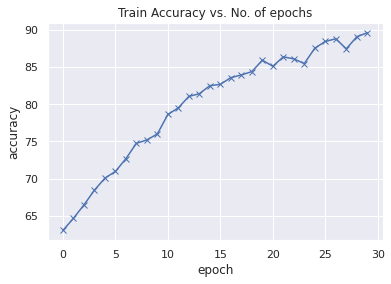

In [ ]:
train_accuracies = [result['epoch'][0] for result in train_results]
plt.plot(train_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train Accuracy vs. No. of epochs');

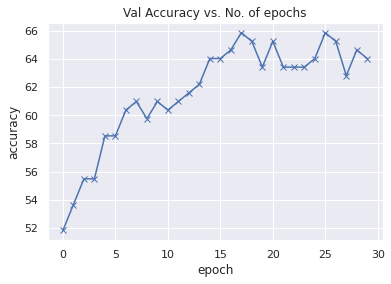

In [ ]:
val_accuracies = [result['epoch'][0] for result in val_results]
plt.plot(val_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Val Accuracy vs. No. of epochs');

In [ ]:
combined = pd.concat([loss_history30, loss_history])

        loss    set  epochs
0   3.975662  train       0
1  37.393436    val       0
2   3.384193  train       1
3  37.968509    val       1
4   2.956356  train       2


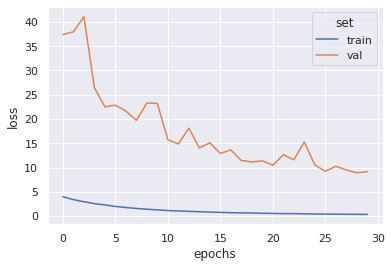

In [ ]:
#Plotting training and validation losses
loss_history = pd.DataFrame(loss_history)
print(loss_history.head())
ax = sns.lineplot(x="epochs", y="loss", hue= "set", data=loss_history)

#Model evaluation using Test data

In [ ]:
#All
file3 = 'phyla_all_753x1177_pmi_0_clr_15p_MAD.csv'

 #stool
#file3 = 'phyla_stool_540x1177_pmi_0_clr_15p_MAD.csv'

 #Biopsy
#file3 = 'phyla_biopsy_213x1177_pmi_0_clr_15p_MAD.csv'

test_data_file = dirc + file3

In [ ]:
class MicrobDataset(Dataset):
  """
  Dataset for binary classification Tumor/Normal
  """
  def __init__(self):
    
    # Select rows whose type is Tumor or Normal
    self.labels = phenotype_df[phenotype_df["uc_cd"].apply(lambda s: s == "IBD" or s == "Control")]

    # Compute categorical embedding, 0 is Normal, 1 is Tumor
    self.labels = self.labels["uc_cd"].apply(lambda s: s == "Control").astype(int)

    # Get corresponding gene expression profiles
    self.X = expr_df

  def __getitem__(self, index):
    sample = np.array(self.X.iloc[index], dtype=np.float32)
    label = np.array(self.labels.iloc[index], dtype=np.float32)

    return sample, label

  def __len__(self):
    return len(self.labels)

In [ ]:
#Reading test data to evaluate the model on test data
#Pandas data read
if test_data_file.endswith('tsv'):
  microbe_df = pd.read_csv(test_data_file, sep='\t')
elif test_data_file.endswith('csv'):
  microbe_df = pd.read_csv(test_data_file)
else:
  print('Please make sure file is either tab separated or comma separated')

#We get indeces of metadata and expression 
metadata_size = 7
col_length = microbe_df.shape[1]
count_colms = col_length - metadata_size
metadata_start = count_colms + 1

#3 Now, we get the features and metadata
expr_df = microbe_df.iloc[:,1:count_colms]
phenotype_df_neat = microbe_df.iloc[:,metadata_start:col_length]
phenotype_df = phenotype_df_neat

#We can set 'sample_title' as index by:
phenotype_df.set_index('sample_title')

#Let's covert UC and CD to IBD
phenotype_df.loc[(phenotype_df.uc_cd == 'CD'), 'uc_cd'] = 'IBD'
phenotype_df.loc[(phenotype_df.uc_cd == 'UC'), 'uc_cd'] = 'IBD'

dataset = MicrobDataset()
num_examples, num_genes = dataset.X.shape

#test_dataset = dataset
#test_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2, generator=torch.Generator().manual_seed(seed))

In [ ]:
#Setting loaders for test data
test_dataset_size = int(len(dataset) * 1)
test_dataset, yx = torch.utils.data.random_split(dataset, lengths=[test_dataset_size, (0)], generator=torch.Generator().manual_seed(seed))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
len(dataset)

753

In [ ]:
model.eval()
print('Accuracy of the network on the test data with ' + str(len(test_dataset)) + ' train samples: %d %%' % compute_accuracy(test_loader, model))
#print('Accuracy = {}, F1-score = {}, Precision = {}, Recall = {}, loss = {}'.format(compute_accuracy_f1(test_loader, model)))

scores = compute_accuracy_f1(test_loader, model)
print('Accuracy = %s, F1-score = %s, Precision = %s, Recall = %s, loss = %s' %(str(scores[0]),str(scores[1]),str(scores[2]),str(scores[3]),str(scores[4])))

Accuracy of the network on the test data with 753 train samples: 65 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Accuracy = 65.47144754316069, F1-score = 0.6024464964866638, Precision = 0.5441988706588745, Recall = 0.6746575236320496, loss = 13.41218513250351


In [ ]:
compute_accuracy_AK(test_loader, model, device)

[{'Accuracy': 65.47144754316069,
  'F1-score': 0.6948356807511737,
  'FN': 95,
  'FP': 165,
  'MCC': 0.30888874710504116,
  'Precision': 0.6420824295010846,
  'Recall': 0.7570332480818415,
  'Specificity': 0.5441988950276243,
  'TN': 197,
  'TP': 296}]